# Examining ice sheet data in python with `Pandas`
## Part 3: Implementing the FöhnDA method on AWS18 data in python with `Pandas`

### Overview

In this notebook, we'll:
1. Read hourly AWS data using `pandas.read_csv` and have pandas index the DataFrame based on a date/time field and interpret the dates.
2. Build on skills developed in parts 1 and 2 of the Pandas introduction.
3. Implement the FohnDA method

## Data/methods references

AWS18 data were produced by Jakobs et al 2020:
> Jakobs, C. L., Reijmer, C. H., Smeets, C. J. P. P., Trusel, L. D., van de Berg, W. J., van den Broeke, M. R., & van Wessem, J. M. (2020). A benchmark dataset of in situ Antarctic surface melt rates and energy balance. Journal of Glaciology, 66(256), 291–302. https://doi.org/10.1017/jog.2020.6

* The local data file is: `data/IMAU_aws18_high-res_meteo_hourly.csv`

* These (and other AWS) data are freely-available here: https://doi.pangaea.de/10.1594/PANGAEA.910480
    * Note: The data in this notebook just have an extra decimal date column and are in CSV rather than tabular format. If using the raw data from Pangaea, there shouldn't need to be any modifications to the code other than changing the file name.

The FöhnDA method for detecting fohn-induced melting was introduced by Laffin et al 2021:
> Laffin, M. K., Zender, C. S., Singh, S., Van Wessem, J. M., Smeets, C. J. P. P., & Reijmer, C. H. (2021). Climatology and Evolution of the Antarctic Peninsula Föhn Wind‐Induced Melt Regime From 1979–2018. Journal of Geophysical Research: Atmospheres, 126(4). https://doi.org/10.1029/2020JD033682

* Here we use a slightly modified version of their method as described later on in this notebook. 

To start, let's import some python packages:

In [52]:
# for data reading
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter # we'll use this in the last step for our fancy plot

# seaborn adds some extra visual appeal to our plots
import seaborn as sns

# set some universal plot settings here
plt.rcParams["figure.dpi"] = 200 # default plot dpi
sns.set_style('darkgrid') # see: https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set_context("notebook", font_scale=0.65) 
%config InlineBackend.figure_format = 'retina' # make high res plots for high res displays
pd.set_option('display.max_columns', None) # show all columns
pd.options.mode.chained_assignment = None  # turn off a specific type of warning

## What does the AWS18 data look like?

In [6]:
# First, tell Jupyter where to find the csv data:
aws18_datafile = './data/IMAU_aws18_high-res_meteo_hourly.csv'

We can use command line functions using a `!` within Jupyter notebooks, like:

In [7]:
# use the command line utility 'head' to look at the csv file:
!head $aws18_datafile

Date/Time,Decimal date [YYYY.yyyyyy],TTT [°C] (at 2m height),THETA [K] (at 2m height),Surf temp [°C] (modelled),Surf temp [°C] (calculated from LWU),Humidity spec [g/kg] (at 2m height),Humidity spec [g/kg] (at surface),RH [%] (at 2m height),ff [m/s] (at 10m height),PPPP [hPa] (at surface),Cloud cov [%],Albedo [%] (24-hour running mean observed...),SZA [deg],Melt energy [W/m**2],Net SW [W/m**2],SWD [W/m**2],SWU [W/m**2],Net LW [W/m**2],LWD [W/m**2],LWU [W/m**2] (modelled),LWU [W/m**2] (observed),NET [W/m**2],Qh [W/m**2],Qe [W/m**2],Ground heat flux [W/m**2],"Melt rate [mm w.e.] (surface melt, within dt)","Melt rate [mm w.e.] (cumulative surface melt, with...)",Runoff [mm] (within dt),Sublimation [mm w.e.] (within dt)
2014-11-25T18:00,2014.900684931507,-4.2556,270.3442,-4.6685,,2.11153,2.62087,77.77113,5.35714,981.35,1.0,0.8520399999999999,0.80399,0.0,111.45102,753.25102,641.8,16.68659,311.29193,294.60534,,128.13761,4.98683,-17.025479999999998,-78.78841,0.0,0.0,0.0,-2.9999999999999997e-0

## Let's use pandas to explore AWS18 data and classify fohn vs non-fohn melting

### First, import the data using `pandas.read_csv` and speciying `parse_dates` and an `index_col`

Try to implement the code below yourself, but if you need help, expand the code below. 


<details>
  <summary>Expand here for help and to see the code.</summary>
    We'd want to tell `Pandas` how to index the data -- in this case, we can use the `Date/Time` column in the data. </br>
    We can also tell it to interpret those dates by specifying parse_dates </br>
    <code>aws18_df = pd.read_csv(aws18_datafile, parse_dates=['Date/Time'], index_col=['Date/Time'])</code>
</details>

In [42]:
# Read the aws18 csv file (enter your code here) 
aws18_df = pd.read_csv(aws18_datafile, parse_dates=['Date/Time'], index_col=['Date/Time'])

## The Fohn effect

We know from the literature that this region, and this AWS specifically is subject to warm, dry, and windy conditions when the fohn effect is active. 

Laffin and coauthors (https://doi.org/10.1029/2020JD033682) for example developed a method termed `FohnDA` to classify in AWS data when a fohn melt event is likely occurring:
1. T2m > 0°C
2. Relative humidity < 30th percentile
3. Wind speed > 60th percentile

We could implement this in Excel and assess fohn vs. non-fohn melting. In fact, we *have* done this! 

But wouldn't it be easier in python and pandas given how easy it is to select and summarize the data? Yes!

## FohnDA in `Pandas`:

Fundamentally, we just need to select locations (i.e., rows) where the three detection criteria are met. 

And since this assignment is most interested in melt, let's use `Surf temp [°C] (modelled)` = 0 instead of T2m > 0°C.

First, let's get the threshold values for humidity and wind speed.
* To do this apply the `DataFrame.quantile` function. 

<details>
  <summary>Expand here for help and to see the code.</summary>
    <code>rh_30th = aws18_df['RH [%] (at 2m height)'].quantile(0.3)</code> </br>
    <code>ws_60th = aws18_df['ff [m/s] (at 10m height)'].quantile(0.6)</code>
</details>


In [43]:
# relative humidity 30th percentile (enter your code here)
rh_30th = aws18_df['RH [%] (at 2m height)'].quantile(0.3)

In [44]:
# wind speed 60th percentile value: (enter your code here)
ws_60th = aws18_df['ff [m/s] (at 10m height)'].quantile(0.6)

In [45]:
# after this, print out the values for each. Do they match what you found in Excel?
print(rh_30th)
print(ws_60th)

80.88441399999999
2.9005620000000003


### Now we just need to find where the three variables are all met:

### Create a column for fohn-induced melt

We want to compare and readily query fohn abd non-fohn melt conditions, so it'll be helpful if we create a new column in the aws18_df where we flag fohn melt first.

In Part 2 of this tutorial, recall that we created new DataFrame fields to track summer vs non-summer melt. We can use that same logic here to track fohn and non-fohn melt conditions.

Here, let's create two new boolean [True/False] columns in our `DataFrame` named fohn_melt and non_fohn_melt. 

<details>
  <summary>Expand here for help and to see the code for classifying fohn melt.</summary>
    <pre><code>aws18_df['fohn_melt'] = (aws18_df['Surf temp [°C] (modelled)']==0) \
                        & (aws18_df['RH [%] (at 2m height)'] &lt rh_30th) \
                        & (aws18_df['ff [m/s] (at 10m height)'] &gt ws_60th)
        </code></pre>
</details>

 
                            
                            
<details>
  <summary>Expand here for help and to see the code for classifying non-fohn melt.</summary>
    <pre><code>aws18_df['non_fohn_melt'] = (aws18_df['fohn_melt']==False) \
                            & (aws18_df['Melt rate [mm w.e.] (surface melt, within dt)']>0)
        </code></pre>
</details>

In [46]:
# classify fohn melt here (enter your code)
aws18_df['fohn_melt'] = (aws18_df['Surf temp [°C] (modelled)']==0) \
                        & (aws18_df['RH [%] (at 2m height)'] < rh_30th) \
                        & (aws18_df['ff [m/s] (at 10m height)'] > ws_60th)

In [47]:
# classify non-fohn melt here (enter your code)
aws18_df['non_fohn_melt'] = (aws18_df['fohn_melt']==False) \
                            & (aws18_df['Melt rate [mm w.e.] (surface melt, within dt)']>0)

In [48]:
# afterwards, show the data table to see that it has the two new columns added
aws18_df

,Decimal date [YYYY.yyyyyy],TTT [°C] (at 2m height),THETA [K] (at 2m height),Surf temp [°C] (modelled),Surf temp [°C] (calculated from LWU),Humidity spec [g/kg] (at 2m height),Humidity spec [g/kg] (at surface),RH [%] (at 2m height),ff [m/s] (at 10m height),PPPP [hPa] (at surface),Cloud cov [%],Albedo [%] (24-hour running mean observed...),SZA [deg],Melt energy [W/m**2],Net SW [W/m**2],SWD [W/m**2],SWU [W/m**2],Net LW [W/m**2],LWD [W/m**2],LWU [W/m**2] (modelled),LWU [W/m**2] (observed),NET [W/m**2],Qh [W/m**2],Qe [W/m**2],Ground heat flux [W/m**2],"Melt rate [mm w.e.] (surface melt, within dt)","Melt rate [mm w.e.] (cumulative surface melt, with...)",Runoff [mm] (within dt),Sublimation [mm w.e.] (within dt),fohn_melt,non_fohn_melt
Date/Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-11-25 18:00:00,2014.900685,-4.2556,270.3442,-4.6685,NaN,2.11153,2.62087,77.77113,5.35714,981.35,1.00000,0.85204,0.80399,0.0,111.45102,753.25102,641.80,16.68659,311.29193,294.60534,NaN,128.13761,4.98683,-17.02548,-78.78841,0.0,0.00000,0.0,-0.00003,False,False
2014-11-25 19:00:00,2014.900799,-5.0427,269.5567,-2.6347,-3.3242,2.10249,3.11529,82.83407,5.41341,981.30,0.81757,0.85259,0.85373,0.0,90.59787,614.59787,524.00,-21.98375,281.65000,303.63375,300.55,68.61412,-29.27064,-36.00842,-3.44296,0.0,0.00000,0.0,-0.04301,False,False
2014-11-25 20:00:00,2014.900913,-5.2380,269.3486,-2.9352,-3.8532,2.07845,3.03686,83.28610,4.75397,981.45,0.84580,0.85311,0.92922,0.0,76.62950,521.67950,445.05,-18.83703,283.45000,302.28703,298.20,57.79247,-25.37518,-30.89714,-1.89310,0.0,0.00000,0.0,-0.04265,False,False
2014-11-25 21:00:00,2014.901027,-5.1380,269.4413,-2.9954,-3.7855,2.10767,3.02114,83.74205,3.17245,981.55,0.85453,0.85349,1.02199,0.0,60.89635,415.64635,354.75,-17.46768,284.55000,302.01768,298.50,43.42867,-17.65067,-22.02611,-3.83853,0.0,0.00000,0.0,-0.03347,False,False
2014-11-25 22:00:00,2014.901142,-5.4491,269.1286,-3.6331,-4.1812,2.07399,2.86226,84.64072,3.39067,981.55,0.88236,0.85388,1.12403,0.0,47.82081,327.27081,279.45,-13.27606,285.90000,299.17606,296.75,34.54475,-15.48389,-19.70145,-0.03201,0.0,0.00000,0.0,-0.02668,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,2018.999429,-2.1420,273.1350,-1.2707,-0.7903,3.15917,3.52238,96.46817,8.70382,973.00,1.00000,0.94710,0.80929,0.0,28.48590,538.48590,510.00,2.19546,312.00000,309.80454,312.00,30.68137,-14.68288,-18.16590,2.01618,0.0,2090.24731,0.0,-0.02185,False,False
2018-12-31 20:00:00,2018.999543,-2.2831,272.9928,-1.6349,-1.3375,3.11771,3.41692,96.33646,8.96292,973.00,0.99106,0.94712,0.88005,0.0,23.17045,438.17045,415.00,-1.14780,307.00000,308.14780,309.50,22.02266,-11.09457,-15.32218,3.85948,0.0,2090.24731,0.0,-0.02139,False,False
2018-12-31 21:00:00,2018.999658,-2.6240,272.6492,-2.1942,-1.5573,3.00586,3.26053,95.58283,10.11748,973.00,0.95042,0.94714,0.97010,0.0,18.80801,355.80801,337.00,-3.61671,302.00000,305.61671,308.50,15.19130,-8.00348,-14.41799,6.72478,0.0,2090.24731,0.0,-0.01919,False,False


### Great! We've implemented FohnDA via pandas!
#### Now we can find the locations (rows/hours) fohn and non-fohn melt conditions and describe them.

Recall that in part 2 of this tutorial, we selected specific data using the `DataFrame.loc` and a some criteria, like:

> ```aws18_df.loc[aws18_df['Melt rate [mm w.e.] (surface melt, within dt)']>0].describe()```

Here, let's select conditions where fohn_melt == True, and then describe.

After that do the same for when non_fohn_melt == True.

*How do these values compare to what you found in Excel?*

<details>
  <summary>Expand here for help and to see code.</summary>
    <pre><code>aws18_df.loc[aws18_df['fohn_melt']==True].describe()
        </code></pre>
</details>

In [49]:
# enter code here to create a descriptive table of fohn melt events 
aws18_df.loc[aws18_df['fohn_melt']==True].describe()

,Decimal date [YYYY.yyyyyy],TTT [°C] (at 2m height),THETA [K] (at 2m height),Surf temp [°C] (modelled),Surf temp [°C] (calculated from LWU),Humidity spec [g/kg] (at 2m height),Humidity spec [g/kg] (at surface),RH [%] (at 2m height),ff [m/s] (at 10m height),PPPP [hPa] (at surface),Cloud cov [%],Albedo [%] (24-hour running mean observed...),SZA [deg],Melt energy [W/m**2],Net SW [W/m**2],SWD [W/m**2],SWU [W/m**2],Net LW [W/m**2],LWD [W/m**2],LWU [W/m**2] (modelled),LWU [W/m**2] (observed),NET [W/m**2],Qh [W/m**2],Qe [W/m**2],Ground heat flux [W/m**2],"Melt rate [mm w.e.] (surface melt, within dt)","Melt rate [mm w.e.] (cumulative surface melt, with...)",Runoff [mm] (within dt),Sublimation [mm w.e.] (within dt)
count,1280.000000,1280.000000,1280.000000,1280.0,1173.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1.280000e+03,1173.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.0,1280.000000
mean,2016.682039,4.954955,279.567589,0.0,0.402955,3.213841,3.878875,58.258316,9.068035,981.834186,0.583571,0.854854,1.438443,70.211000,39.649177,223.352912,183.703735,-25.168981,290.467999,3.156370e+02,317.509168,14.480196,83.837522,-29.092922,-0.336733,0.738344,1167.452171,0.0,-0.037997
std,1.083594,2.422899,2.238144,0.0,0.467968,0.475886,0.040086,8.349681,4.706572,10.101802,0.213518,0.056218,0.456647,58.287663,52.079971,261.567715,211.814733,25.830639,25.830639,5.686564e-14,2.166067,41.619328,56.888903,26.627852,3.275858,0.612672,501.152752,0.0,0.030559
min,2014.922374,-3.473400,271.586000,0.0,-2.453100,1.858770,3.788290,36.154720,2.911400,953.750000,0.004630,0.736210,0.753850,0.072660,0.000000,0.000000,0.000000,-99.936980,215.700000,3.156370e+02,304.450000,-65.151170,-29.161190,-130.129820,-60.297900,-0.000000,14.190900,0.0,-0.162040
25%,2016.000427,3.699875,278.468575,0.0,0.225400,2.937457,3.849120,53.039915,5.201387,974.237500,0.447958,0.811725,1.026795,27.927215,0.427165,3.261013,2.900000,-40.677080,274.959900,3.156370e+02,316.680000,-17.001205,41.147390,-44.003695,0.000000,0.288750,737.880927,0.0,-0.054352
50%,2016.400216,5.087250,279.700850,0.0,0.433400,3.180755,3.876220,57.273580,8.109970,982.400000,0.609030,0.854640,1.392055,56.805425,11.715295,98.286915,84.525000,-22.889580,292.747400,3.156370e+02,317.645200,5.150830,76.809565,-24.689385,0.000000,0.586270,1140.147010,0.0,-0.031005
75%,2017.234047,6.265250,280.787150,0.0,0.638800,3.472637,3.908780,62.379957,12.115720,989.300000,0.740943,0.898872,1.785695,97.427850,66.068072,399.292087,333.550000,-7.353880,308.283100,3.156370e+02,318.600000,41.805835,115.832548,-11.179642,0.000000,1.016075,1646.308110,0.0,-0.014790
max,2018.977740,15.051600,289.213800,0.0,1.792400,5.660390,3.992940,80.733320,27.950140,1005.150000,1.000000,0.950000,2.383770,441.319390,219.212890,1018.569680,848.000000,65.348220,380.985200,3.156370e+02,324.003600,172.335910,338.747750,77.091630,0.000000,4.517520,2052.714810,0.0,0.009430


In [50]:
# enter code here to create a descriptive table of non-fohn melt events 
aws18_df.loc[aws18_df['non_fohn_melt']==True].describe()

,Decimal date [YYYY.yyyyyy],TTT [°C] (at 2m height),THETA [K] (at 2m height),Surf temp [°C] (modelled),Surf temp [°C] (calculated from LWU),Humidity spec [g/kg] (at 2m height),Humidity spec [g/kg] (at surface),RH [%] (at 2m height),ff [m/s] (at 10m height),PPPP [hPa] (at surface),Cloud cov [%],Albedo [%] (24-hour running mean observed...),SZA [deg],Melt energy [W/m**2],Net SW [W/m**2],SWD [W/m**2],SWU [W/m**2],Net LW [W/m**2],LWD [W/m**2],LWU [W/m**2] (modelled),LWU [W/m**2] (observed),NET [W/m**2],Qh [W/m**2],Qe [W/m**2],Ground heat flux [W/m**2],"Melt rate [mm w.e.] (surface melt, within dt)","Melt rate [mm w.e.] (cumulative surface melt, with...)",Runoff [mm] (within dt),Sublimation [mm w.e.] (within dt)
count,2517.000000,2517.000000,2517.000000,2517.000000,2262.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2262.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.0,2517.000000
mean,2016.633067,0.763573,275.434039,-0.053653,0.632549,3.154119,3.866002,77.421108,2.291409,980.841948,0.591236,0.839215,0.986865,42.251965,84.296900,511.989361,427.692461,-36.599142,278.790952,315.390095,318.597890,47.697758,2.270806,-10.757626,1.366464,0.454973,1114.818841,0.0,-0.013876
std,1.243836,2.282417,2.259428,0.202982,1.029969,0.449337,0.068601,11.009008,2.444936,8.811972,0.295045,0.050590,0.233649,38.144510,48.468318,223.224586,184.699852,28.235146,28.308325,0.928852,4.781218,38.473987,16.667505,12.569492,5.548939,0.396761,652.992861,0.0,0.014987
min,2014.903082,-6.881800,267.110700,-3.954700,-4.181200,1.831590,2.727980,44.068390,0.222930,950.000000,0.000000,0.730920,0.750290,0.000000,0.000000,0.000000,0.000000,-99.636980,216.000000,297.750930,296.750000,-69.085130,-72.062730,-118.915590,-23.189530,0.000010,0.366790,0.0,-0.165730
25%,2015.907877,-0.847500,273.916000,0.000000,0.034625,2.873330,3.846400,70.019430,1.037620,975.000000,0.303140,0.799800,0.823910,8.849080,46.888840,363.960200,306.000000,-61.876980,253.350000,315.636980,315.797000,23.829100,-4.658810,-14.547410,0.000000,0.124680,600.599470,0.0,-0.018360
50%,2016.881717,0.368200,275.124300,0.000000,0.714000,3.133050,3.873850,78.489070,1.677320,980.900000,0.653220,0.837590,0.918110,36.474460,80.164360,553.668880,463.000000,-30.936980,284.653600,315.636980,318.950000,46.047230,1.066510,-7.995930,0.000000,0.381100,1330.491000,0.0,-0.010790
75%,2017.234361,2.113300,276.756500,0.000000,1.322700,3.419930,3.901700,85.893740,2.548090,987.100000,0.854210,0.873650,1.073870,65.592730,119.439740,682.105260,572.800000,-13.466080,302.000000,315.636980,321.795200,71.496280,4.689210,-2.849560,0.000000,0.690840,1648.729670,0.0,-0.004160
max,2018.996918,11.568100,286.411700,0.000000,3.794400,5.850270,4.004520,100.151100,23.503580,1005.000000,1.000000,0.950000,2.373790,203.440910,226.628280,1005.000960,836.000000,26.845820,342.482800,315.636980,333.544000,193.387440,146.236170,11.171070,62.880080,2.128620,2090.247310,0.0,0.002700


### And we can define and query only the columns we're most interested in rather than looking at all data descriptions:

This creates a string array with the column names that we can then use to select:

## Now let's create variables that track cumulative fohn and non-fohn melt hours

* Need to implement this using some if/then type logic. 
* The basics are:
    * Create a new column that will hold a counter value for consecutive hours of melt
    * If a current hour is melting set the counter to 1 + what was in the previous counter value
        * Thus, a single hour of melt = 1
        * If this is followed by another melt hour we get 1 + 1

In [53]:
# Track cumulative fohn hours
# first, create a blank column
aws18_df['fohn_consec_hours'] = 0

# for every row in the range of the length of the dataframe
# len gives the length (i.e., total number of data rows)
# range iterates through the rows (i.e., 0, 1, 2, 3 ... n)

for i in range(len(aws18_df)):
    # check if this row holds a fohn melt event
    if aws18_df['fohn_melt'][i]==True:
        # if true, in set the melt counter value for this row (hour) to 1 plus the value from the previous row (hour)
        aws18_df['fohn_consec_hours'][i]=1 + aws18_df['fohn_consec_hours'][i-1]
    else:
        # otherwise set the value in this row to zero (i.e, there's no melt)
        aws18_df['fohn_consec_hours'][i]=0

In [54]:
# Track cumulative non-fohn hours
# first, create a blank column
aws18_df['non_fohn_consec_hours'] = 0

for i in range(len(aws18_df)):
    # check if this row holds a non-fohn melt event
    if aws18_df['non_fohn_melt'][i]==True:
        # if true, in set the melt counter value for this row (hour) to 1 plus the value from the previous row (hour)
        aws18_df['non_fohn_consec_hours'][i]=1 + aws18_df['non_fohn_consec_hours'][i-1]
    else:
        # otherwise set the value in this row to zero (i.e, there's no melt)
        aws18_df['non_fohn_consec_hours'][i]=0

## Now we can get info about the maximum consecutive duration fohn and non-fohn melt events:

Looking the max values in the descriptive table will work:

In [55]:
aws18_df.describe()

,Decimal date [YYYY.yyyyyy],TTT [°C] (at 2m height),THETA [K] (at 2m height),Surf temp [°C] (modelled),Surf temp [°C] (calculated from LWU),Humidity spec [g/kg] (at 2m height),Humidity spec [g/kg] (at surface),RH [%] (at 2m height),ff [m/s] (at 10m height),PPPP [hPa] (at surface),Cloud cov [%],Albedo [%] (24-hour running mean observed...),SZA [deg],Melt energy [W/m**2],Net SW [W/m**2],SWD [W/m**2],SWU [W/m**2],Net LW [W/m**2],LWD [W/m**2],LWU [W/m**2] (modelled),LWU [W/m**2] (observed),NET [W/m**2],Qh [W/m**2],Qe [W/m**2],Ground heat flux [W/m**2],"Melt rate [mm w.e.] (surface melt, within dt)","Melt rate [mm w.e.] (cumulative surface melt, with...)",Runoff [mm] (within dt),Sublimation [mm w.e.] (within dt),fohn_consec_hours,non_fohn_consec_hours
count,35933.000000,35933.000000,35933.000000,35933.000000,31393.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,31393.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.000000,35933.0,35933.000000,35933.000000,35933.000000
mean,2016.949883,-12.102325,262.550391,-12.767431,-12.547639,1.500919,1.778117,83.298452,3.565195,980.208288,0.662874,0.895634,1.561526,5.460672,17.904067,134.450449,116.546381,-18.941742,244.097080,263.038822,264.083061,-1.037675,8.970364,-7.256590,4.452251,0.058171,1284.737140,0.0,-0.009271,0.262099,0.340161
std,1.183072,10.992096,11.125520,10.268685,10.609074,1.053086,1.278298,13.065125,3.508489,11.170296,0.304174,0.053370,0.401652,22.218300,32.654881,205.957041,176.429124,23.248693,37.888525,40.226948,41.557918,28.393418,29.701746,13.016994,13.683198,0.234350,574.482258,0.0,0.016193,2.047931,1.595308
min,2014.900685,-44.222300,227.764200,-43.077100,-43.757500,0.044670,0.051270,31.444470,0.222930,943.000000,0.000000,0.634330,0.750290,0.000000,0.000000,0.000000,0.000000,-99.936980,127.600000,158.871190,157.000000,-85.999130,-84.559250,-145.943770,-82.664750,0.000000,0.000000,0.0,-0.179940,0.000000,0.000000
25%,2015.926142,-21.005900,253.541000,-21.168000,-21.055600,0.525840,0.575660,77.419610,1.401500,972.700000,0.439540,0.862080,1.278880,0.000000,0.210530,2.842110,2.650000,-31.952980,216.000000,228.591980,229.000000,-14.083180,-4.982730,-8.863620,-1.886880,0.000000,631.303000,0.0,-0.011360,0.000000,0.000000
50%,2016.948998,-10.556800,264.099600,-11.181100,-10.702600,1.297570,1.477500,88.195160,2.357140,980.500000,0.789090,0.910440,1.565360,0.000000,1.117320,11.578950,10.150000,-10.350670,242.550000,267.043550,269.000000,-1.139960,-0.224660,-2.496180,3.293330,0.000000,1402.202110,0.0,-0.003220,0.000000,0.000000
75%,2017.974315,-2.804400,272.038200,-3.356400,-2.887600,2.420110,2.942150,92.679650,4.072800,988.000000,0.906700,0.943660,1.842530,0.000000,21.136840,203.283610,179.400000,-1.351060,275.000000,300.406820,302.500000,8.168650,8.075350,-0.706300,11.262770,0.000000,1794.419470,0.0,-0.000920,0.000000,0.000000
max,2018.999886,15.051600,289.213800,0.000000,3.794400,5.850270,4.004520,100.577340,27.950140,1018.000000,1.000000,0.950000,2.390800,441.319390,226.628280,1018.569680,848.000000,65.348220,380.985200,315.636980,333.544000,193.387440,338.747750,77.091630,95.942260,4.517520,2090.247310,0.0,0.040040,50.000000,33.000000


Or by just querying the max value:

In [56]:
max_fohn_melt_hrs = aws18_df['fohn_consec_hours'].max()
max_nonfohn_melt_hrs = aws18_df['non_fohn_consec_hours'].max()

print("Maximum consecutive hours of fohn-induced melt: " + str(max_fohn_melt_hrs))
print("Maximum consecutive hours of non-fohn-induced melt: " + str(max_nonfohn_melt_hrs))

Maximum consecutive hours of fohn-induced melt: 50
Maximum consecutive hours of non-fohn-induced melt: 33


### But when did the longest fohn melt event occur? 

We can use `idxmax` which gives the index value of the maximum value.

* See: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html

>Return index of first occurrence of maximum over requested axis.

And we have Date/Time as our index, so it'll give us that:


In [33]:
max_fohn_time = aws18_df['fohn_consec_hours'].idxmax()
max_fohn_time

Timestamp('2016-05-27 10:00:00')

In [34]:
# Show us everything in that row
aws18_df.loc[max_fohn_time]

Decimal date [YYYY.yyyyyy]                                2016.402664
TTT [°C] (at 2m height)                                        7.1854
THETA [K] (at 2m height)                                     281.4503
Surf temp [°C] (modelled)                                         0.0
Surf temp [°C] (calculated from LWU)                           0.3993
Humidity spec [g/kg] (at 2m height)                           3.57845
Humidity spec [g/kg] (at surface)                             3.86125
RH [%] (at 2m height)                                        55.74117
ff [m/s] (at 10m height)                                      3.62339
PPPP [hPa] (at surface)                                         986.2
Cloud cov [%]                                                 0.83677
Albedo [%] (24-hour running mean observed...)                 0.90916
SZA [deg]                                                     2.03327
Melt energy [W/m**2]                                         46.14839
Net SW [W/m**2]     

### But what about when it started?

This is definitely a bit trickier. It requires thinking programmatically and understanding/Googling some of the finer details of `pandas` indexing. 

In [35]:
# get the numerical index value (i.e., row number) at the time of maximum fohn melt duration
max_index = aws18_df.index.get_loc(max_fohn_time)
max_index

13168

This tell us the row number where this max fohn duration value occurs.

Now if we want to find when it started, we just need to subtract the number of fohn melt hours minus 1 from this row number.

Then we can see what's in this row (especially the index value, which we set to the Date/Time column)

In [36]:
# length of event minus 1 hour will tell us when it started
# recall aws18_df['fohn_consec_hours'].max() tells us the max duration (50 hours, here)
n_hrs_previous = int(aws18_df['fohn_consec_hours'].max() - 1)

# now give the index (date/time) of when this was
aws18_df.index[max_index - n_hrs_previous]

Timestamp('2016-05-25 09:00:00')

Now we know when it started, we can also just see what else what happening then, and make sure it looks like we've selected the correct start time.

In [ ]:
aws18_df.loc['2016-05-25 09:00:00']

## Let's make a plot of all melt, and highlight fohn melt

### First, let's convert hourly data to daily max values using the `pandas.DataFrame.resample` function:
This type of resampling is incredibly easy! In fact, this is what I used when we were exploring daily A2 data -- I just resampled from hourly to daily. This sort of operation would be much, much more difficult and time consuming to implement in Excel, and much more prone to introducing errors.

Documentation here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
> Resample time-series data.

> Convenience method for frequency conversion and resampling of time series. Object must have a datetime-like index (DatetimeIndex, PeriodIndex, or TimedeltaIndex), or pass datetime-like values to the on or level keyword.

In [37]:
# convert to daily maxes
aws18_daily = aws18_df.resample('D').max()

## Now let's move on to making a nice-looking plot to explore the timing of fohn-induced melt and its relation to melt rates.

Below, I've written some code that plots daily max melt data and shows the fohn-induced melt as vertical blue bars.

I've set plotting function up in a `for` loop to to produce a plot in every year that I've defined in a list of strings.

The plot has two axes -- one for the melt data, one for the Boolean True/False for fohn_melt, which in the plot convert to an integer field where 1=True. As such, I limit the axis with the fohn melt to between 0 and 1.

Both data series are plotted using the [`matplotlib.pyplot.fill_between`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html) method, which gives the step-line appearance as opposed to lines. This works especially well here as we want to shade the areas of fohn-induced melt. 

2015


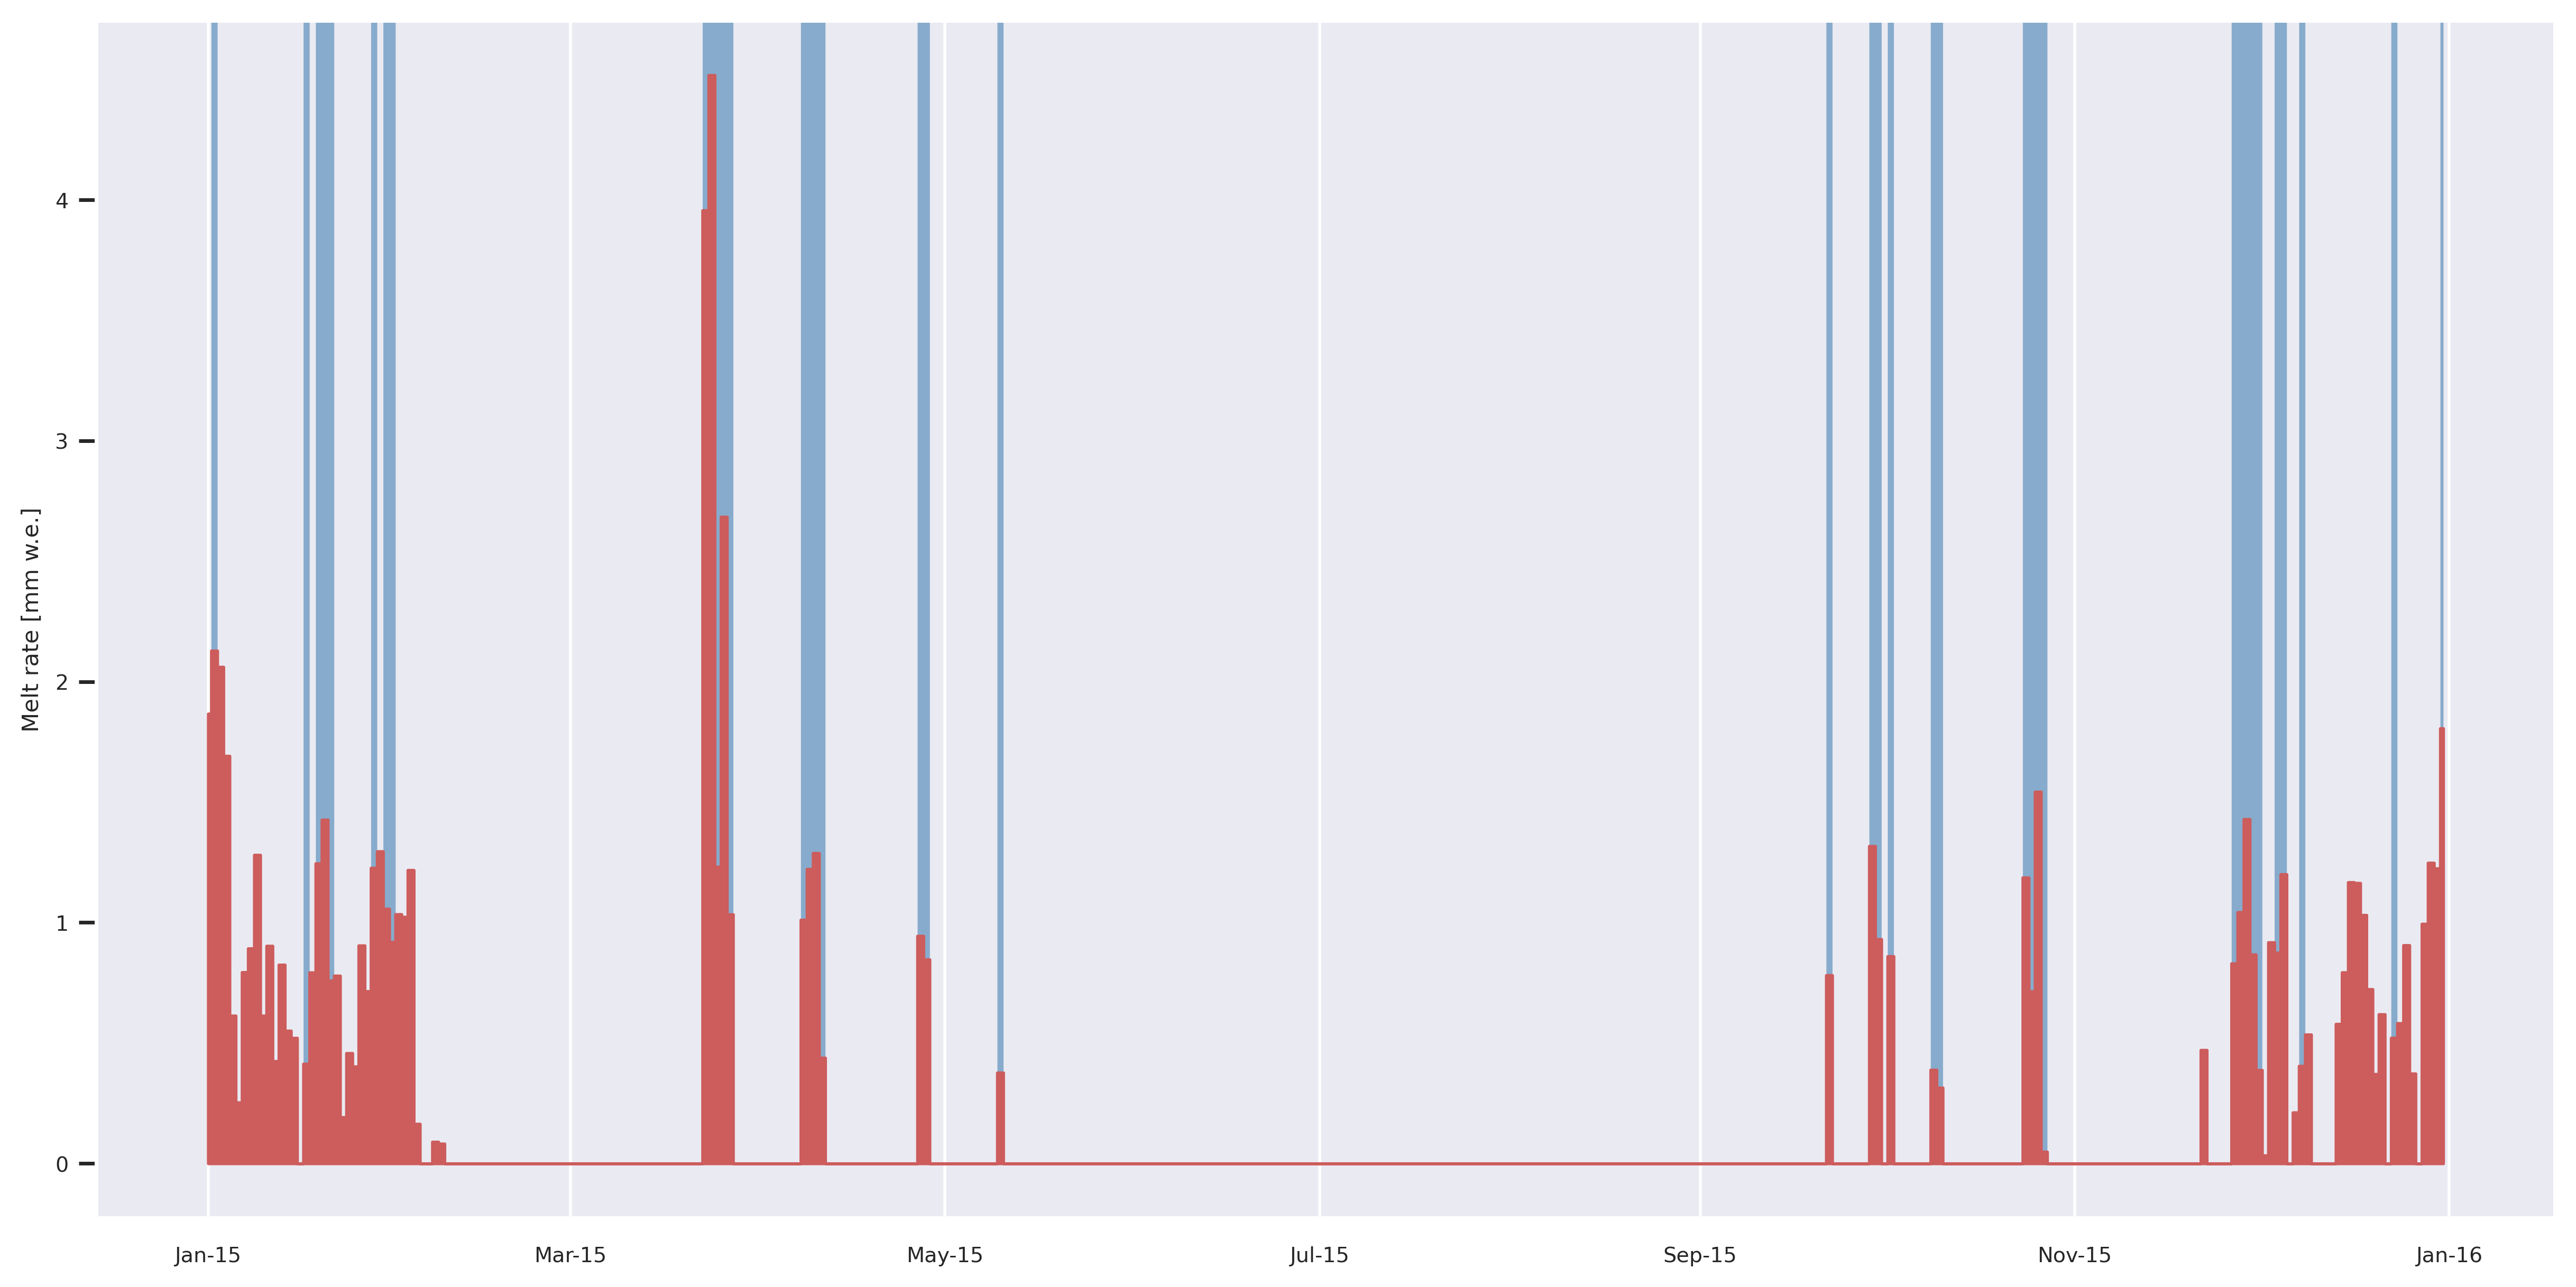

2016


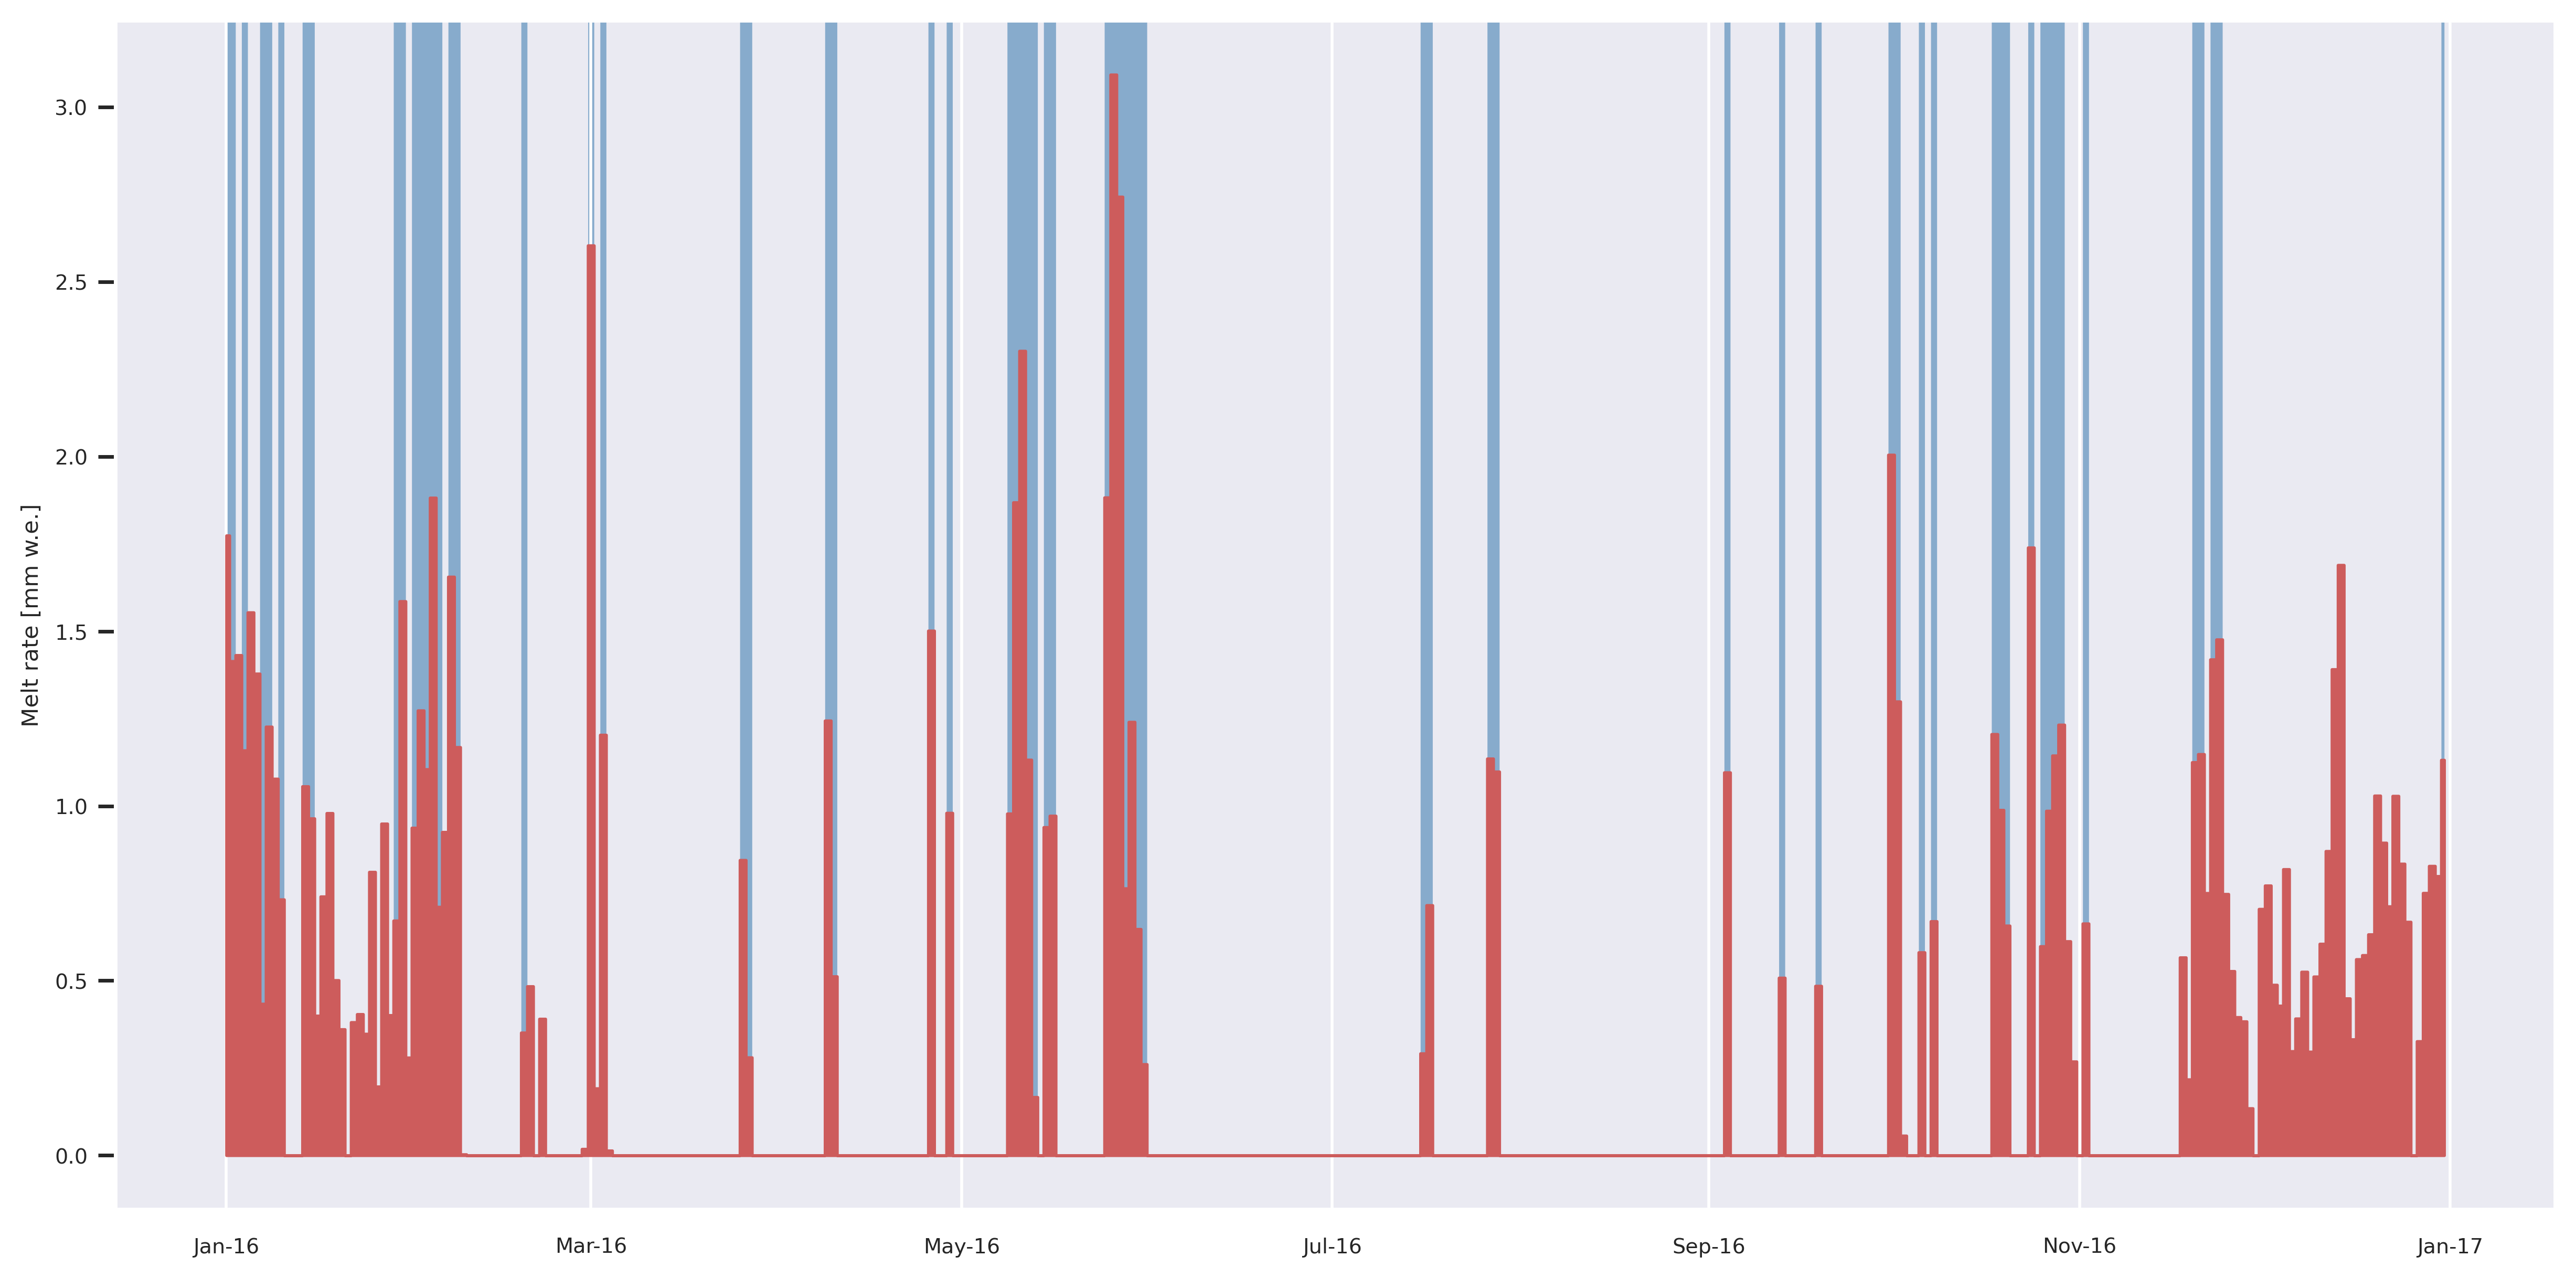

2017


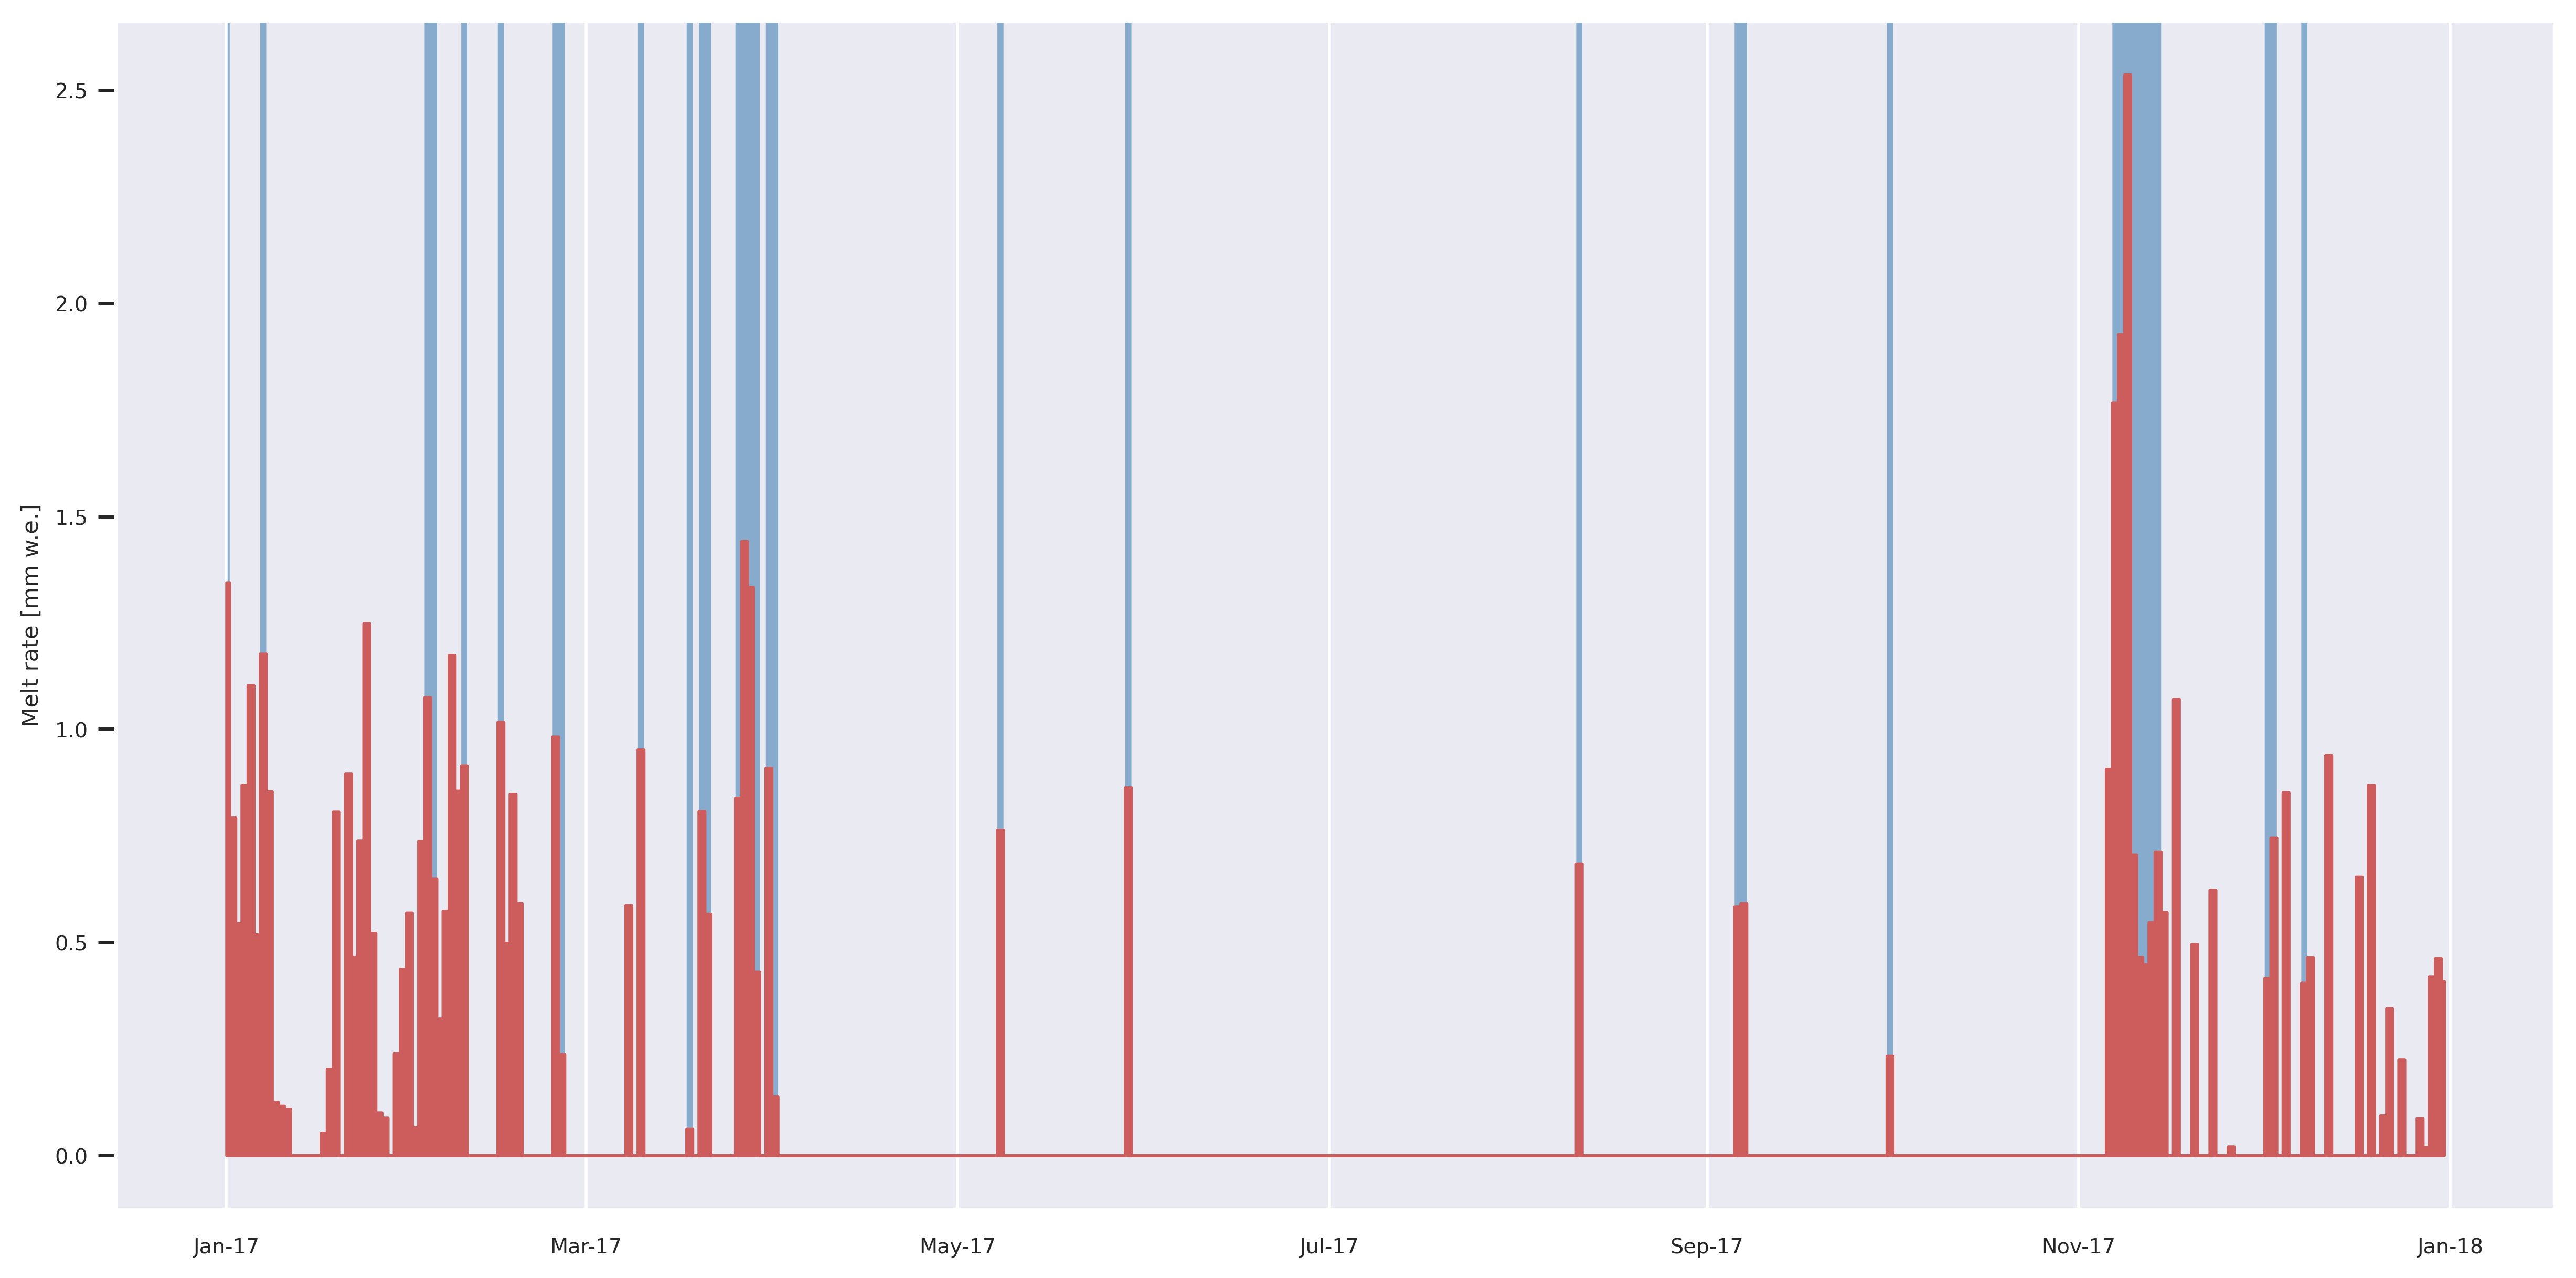

2018


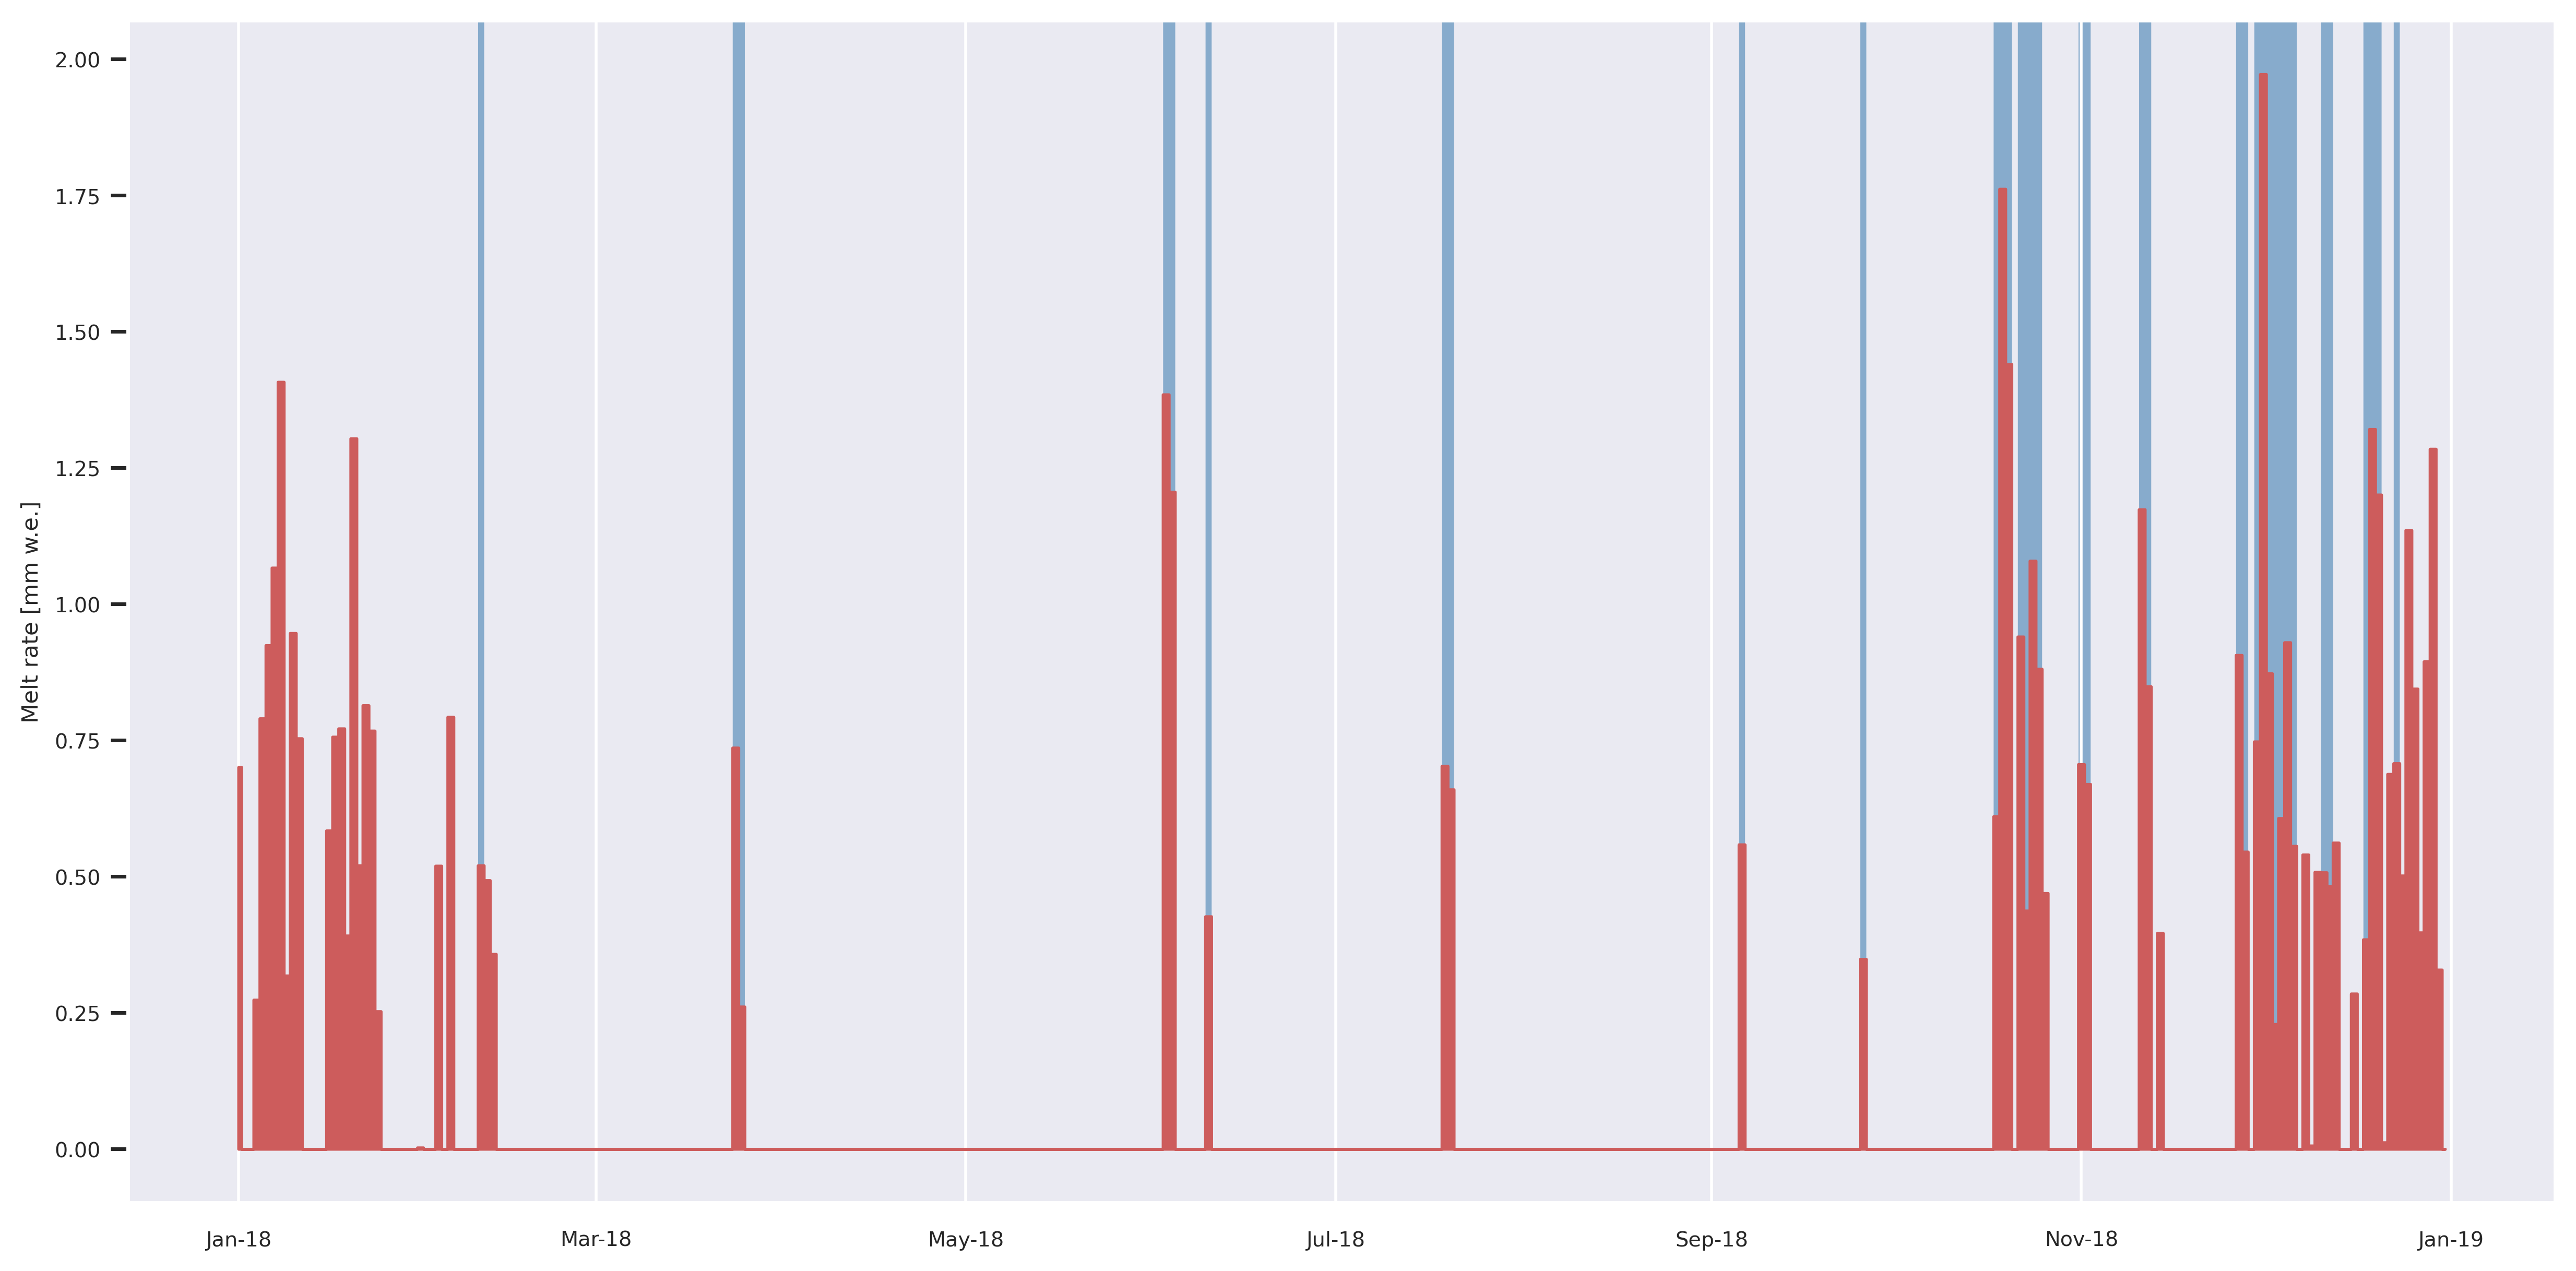

In [40]:
# manually define an array of years as string values (i.e., in single quotes)
years = ['2015','2016','2017','2018']

for i in range(len(years)):
    
    # for the current iteration, i, reference the vale from the 'years' array we defined above
    year = years[i]
    
    # print out what year we're currently working with
    print(year)
    
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(15, 7.5))

    # subset in time based on the current year
    aws18_daily_sub = aws18_daily.loc[year+'-01':year+'-12']

    # shade areas where there's fohn-induced melt
    bg_steps = ax.fill_between(aws18_daily_sub.index.values,
                           aws18_daily_sub['fohn_melt'].astype(int),
                           label="FohnDA melt",
                           facecolor='steelblue',
                           step="mid",
                           linewidth=0,
                           alpha=0.6,
                           zorder=-1)

    # create a second y-axis to plot the melt data on
    ax2 = ax.twinx()
    melt_steps = ax2.fill_between(aws18_daily_sub.index.values,
                    aws18_daily_sub['Melt rate [mm w.e.] (surface melt, within dt)'],
                    label="Melt rate",
                    color="indianred",
                    step="mid",
                    zorder=1)

    # set some chart and axis properties
    ax.set_ylim((-0.05, 1))
    ax.yaxis.grid(False)
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks([])
    ax2.yaxis.grid(False)
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()

    # Set title and labels for axes
    ax2.set(ylabel="Melt rate [mm w.e.]")

    # Define the date format
    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_formatter(date_form)

    plt.show()